In [3]:
%reset 

In [4]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2022.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""The variational quantum eigensolver algorithm."""

from __future__ import annotations

import logging
from time import time
from collections.abc import Callable, Sequence
from typing import Any

import numpy as np

from qiskit.algorithms.gradients import BaseEstimatorGradient
from qiskit.circuit import QuantumCircuit
from qiskit.opflow import PauliSumOp
from qiskit.primitives import BaseEstimator
from qiskit.quantum_info.operators.base_operator import BaseOperator

from qiskit.algorithms.exceptions import AlgorithmError
from qiskit.algorithms.list_or_dict import ListOrDict
from qiskit.algorithms.optimizers import Optimizer, Minimizer, OptimizerResult
from qiskit.algorithms.variational_algorithm import VariationalAlgorithm, VariationalResult
from qiskit.algorithms.minimum_eigensolvers import MinimumEigensolver, MinimumEigensolverResult
from qiskit.algorithms.observables_evaluator import estimate_observables
from qiskit.algorithms.utils import validate_initial_point, validate_bounds

# private function as we expect this to be updated in the next released
from qiskit.algorithms.utils.set_batching import _set_default_batchsize

logger = logging.getLogger(__name__)


class VQE(VariationalAlgorithm, MinimumEigensolver):
    r"""The variational quantum eigensolver (VQE) algorithm.

    VQE is a hybrid quantum-classical algorithm that uses a variational technique to find the
    minimum eigenvalue of a given Hamiltonian operator :math:`H`.

    The ``VQE`` algorithm is executed using an :attr:`estimator` primitive, which computes
    expectation values of operators (observables).

    An instance of ``VQE`` also requires an :attr:`ansatz`, a parameterized
    :class:`.QuantumCircuit`, to prepare the trial state :math:`|\psi(\vec\theta)\rangle`. It also
    needs a classical :attr:`optimizer` which varies the circuit parameters :math:`\vec\theta` such
    that the expectation value of the operator on the corresponding state approaches a minimum,

    .. math::

        \min_{\vec\theta} \langle\psi(\vec\theta)|H|\psi(\vec\theta)\rangle.

    The :attr:`estimator` is used to compute this expectation value for every optimization step.

    The optimizer can either be one of Qiskit's optimizers, such as
    :class:`~qiskit.algorithms.optimizers.SPSA` or a callable with the following signature:

    .. code-block:: python

        from qiskit.algorithms.optimizers import OptimizerResult

        def my_minimizer(fun, x0, jac=None, bounds=None) -> OptimizerResult:
            # Note that the callable *must* have these argument names!
            # Args:
            #     fun (callable): the function to minimize
            #     x0 (np.ndarray): the initial point for the optimization
            #     jac (callable, optional): the gradient of the objective function
            #     bounds (list, optional): a list of tuples specifying the parameter bounds

            result = OptimizerResult()
            result.x = # optimal parameters
            result.fun = # optimal function value
            return result

    The above signature also allows one to use any SciPy minimizer, for instance as

    .. code-block:: python

        from functools import partial
        from scipy.optimize import minimize

        optimizer = partial(minimize, method="L-BFGS-B")

    The following attributes can be set via the initializer but can also be read and updated once
    the VQE object has been constructed.

    Attributes:
        estimator (BaseEstimator): The estimator primitive to compute the expectation value of the
            Hamiltonian operator.
        ansatz (QuantumCircuit): A parameterized quantum circuit to prepare the trial state.
        optimizer (Optimizer | Minimizer): A classical optimizer to find the minimum energy. This
            can either be a Qiskit :class:`.Optimizer` or a callable implementing the
            :class:`.Minimizer` protocol.
        gradient (BaseEstimatorGradient | None): An optional estimator gradient to be used with the
            optimizer.
        callback (Callable[[int, np.ndarray, float, dict[str, Any]], None] | None): A callback that
            can access the intermediate data at each optimization step. These data are: the
            evaluation count, the optimizer parameters for the ansatz, the evaluated mean, and the
            metadata dictionary.

    References:
        [1]: Peruzzo, A., et al, "A variational eigenvalue solver on a quantum processor"
            `arXiv:1304.3061 <https://arxiv.org/abs/1304.3061>`__
    """

    def __init__(
        self,
        estimator: BaseEstimator,
        ansatz: QuantumCircuit,
        optimizer: Optimizer | Minimizer,
        *,
        gradient: BaseEstimatorGradient | None = None,
        initial_point: Sequence[float] | None = None,
        callback: Callable[[int, np.ndarray, float, dict[str, Any]], None] | None = None,
    ) -> None:
        r"""
        Args:
            estimator: The estimator primitive to compute the expectation value of the
                Hamiltonian operator.
            ansatz: A parameterized quantum circuit to prepare the trial state.
            optimizer: A classical optimizer to find the minimum energy. This can either be a
                Qiskit :class:`.Optimizer` or a callable implementing the :class:`.Minimizer`
                protocol.
            gradient: An optional estimator gradient to be used with the optimizer.
            initial_point: An optional initial point (i.e. initial parameter values) for the
                optimizer. The length of the initial point must match the number of :attr:`ansatz`
                parameters. If ``None``, a random point will be generated within certain parameter
                bounds. ``VQE`` will look to the ansatz for these bounds. If the ansatz does not
                specify bounds, bounds of :math:`-2\pi`, :math:`2\pi` will be used.
            callback: A callback that can access the intermediate data at each optimization step.
                These data are: the evaluation count, the optimizer parameters for the ansatz, the
                estimated value, and the metadata dictionary.
        """
        super().__init__()

        self.estimator = estimator
        self.ansatz = ansatz
        self.optimizer = optimizer
        self.gradient = gradient
        # this has to go via getters and setters due to the VariationalAlgorithm interface
        self.initial_point = initial_point
        self.callback = callback

    @property
    def initial_point(self) -> Sequence[float] | None:
        return self._initial_point

    @initial_point.setter
    def initial_point(self, value: Sequence[float] | None) -> None:
        self._initial_point = value

    def compute_minimum_eigenvalue(
        self,
        operator: BaseOperator | PauliSumOp,
        aux_operators: ListOrDict[BaseOperator | PauliSumOp] | None = None,
    ) -> VQEResult:
        self._check_operator_ansatz(operator)

        initial_point = validate_initial_point(self.initial_point, self.ansatz)

        bounds = validate_bounds(self.ansatz)

        start_time = time()

        evaluate_energy = self._get_evaluate_energy(self.ansatz, operator)

        if self.gradient is not None:
            evaluate_gradient = self._get_evaluate_gradient(self.ansatz, operator)
        else:
            evaluate_gradient = None

        # perform optimization
        if callable(self.optimizer):
            optimizer_result = self.optimizer(
                fun=evaluate_energy, x0=initial_point, jac=evaluate_gradient, bounds=bounds
            )
        else:
            # we always want to submit as many estimations per job as possible for minimal
            # overhead on the hardware
            was_updated = _set_default_batchsize(self.optimizer)

            optimizer_result = self.optimizer.minimize(
                fun=evaluate_energy, x0=initial_point, jac=evaluate_gradient, bounds=bounds
            )

            # reset to original value
            if was_updated:
                self.optimizer.set_max_evals_grouped(None)

        optimizer_time = time() - start_time

        logger.info(
            "Optimization complete in %s seconds.\nFound optimal point %s",
            optimizer_time,
            optimizer_result.x,
        )

        if aux_operators is not None:
            aux_operators_evaluated = estimate_observables(
                self.estimator, self.ansatz, aux_operators, optimizer_result.x
            )
        else:
            aux_operators_evaluated = None

        return self._build_vqe_result(
            self.ansatz, optimizer_result, aux_operators_evaluated, optimizer_time
        )


    @classmethod
    def supports_aux_operators(cls) -> bool:
        return True


    def _get_evaluate_energy(
        self,
        ansatz: QuantumCircuit,
        operator: BaseOperator | PauliSumOp,
    ) -> Callable[[np.ndarray], np.ndarray | float]:
        """Returns a function handle to evaluate the energy at given parameters for the ansatz.
        This is the objective function to be passed to the optimizer that is used for evaluation.

        Args:
            ansatz: The ansatz preparing the quantum state.
            operator: The operator whose energy to evaluate.

        Returns:
            A callable that computes and returns the energy of the hamiltonian of each parameter.

        Raises:
            AlgorithmError: If the primitive job to evaluate the energy fails.
        """
        num_parameters = ansatz.num_parameters

        # avoid creating an instance variable to remain stateless regarding results
        eval_count = 0

        def evaluate_energy(parameters: np.ndarray) -> np.ndarray | float:
            nonlocal eval_count

            # handle broadcasting: ensure parameters is of shape [array, array, ...]
            parameters = np.reshape(parameters, (-1, num_parameters)).tolist()
            batch_size = len(parameters)

            try:
                job = self.estimator.run(batch_size * [ansatz], batch_size * [operator], parameters)
                estimator_result = job.result()
            except Exception as exc:
                raise AlgorithmError("The primitive job to evaluate the energy failed!") from exc

            values = estimator_result.values

            if self.callback is not None:
                metadata = estimator_result.metadata
                for params, value, meta in zip(parameters, values, metadata):
                    eval_count += 1
                    self.callback(eval_count, params, value, meta)

            energy = values[0] if len(values) == 1 else values

            return energy

        return evaluate_energy

    def _get_evaluate_gradient(
        self,
        ansatz: QuantumCircuit,
        operator: BaseOperator | PauliSumOp,
    ) -> Callable[[np.ndarray], np.ndarray]:
        """Get a function handle to evaluate the gradient at given parameters for the ansatz.

        Args:
            ansatz: The ansatz preparing the quantum state.
            operator: The operator whose energy to evaluate.

        Returns:
            A function handle to evaluate the gradient at given parameters for the ansatz.

        Raises:
            AlgorithmError: If the primitive job to evaluate the gradient fails.
        """

        def evaluate_gradient(parameters: np.ndarray) -> np.ndarray:
            # broadcasting not required for the estimator gradients
            try:
                job = self.gradient.run([ansatz], [operator], [parameters])
                gradients = job.result().gradients
            except Exception as exc:
                raise AlgorithmError("The primitive job to evaluate the gradient failed!") from exc

            return gradients[0]

        return evaluate_gradient

    def _check_operator_ansatz(self, operator: BaseOperator | PauliSumOp):
        """Check that the number of qubits of operator and ansatz match and that the ansatz is
        parameterized.
        """
        if operator.num_qubits != self.ansatz.num_qubits:
            try:
                logger.info(
                    "Trying to resize ansatz to match operator on %s qubits.", operator.num_qubits
                )
                self.ansatz.num_qubits = operator.num_qubits
            except AttributeError as error:
                raise AlgorithmError(
                    "The number of qubits of the ansatz does not match the "
                    "operator, and the ansatz does not allow setting the "
                    "number of qubits using `num_qubits`."
                ) from error

        if self.ansatz.num_parameters == 0:
            raise AlgorithmError("The ansatz must be parameterized, but has no free parameters.")

    def _build_vqe_result(
        self,
        ansatz: QuantumCircuit,
        optimizer_result: OptimizerResult,
        aux_operators_evaluated: ListOrDict[tuple[complex, tuple[complex, int]]],
        optimizer_time: float,
    ) -> VQEResult:
        result = VQEResult()
        result.optimal_circuit = ansatz.copy()
        result.eigenvalue = optimizer_result.fun
        result.cost_function_evals = optimizer_result.nfev
        result.optimal_point = optimizer_result.x
        result.optimal_parameters = dict(zip(self.ansatz.parameters, optimizer_result.x))
        result.optimal_value = optimizer_result.fun
        result.optimizer_time = optimizer_time
        result.aux_operators_evaluated = aux_operators_evaluated
        result.optimizer_result = optimizer_result
        return result



class VQEResult(VariationalResult, MinimumEigensolverResult):
    """Variational quantum eigensolver result."""

    def __init__(self) -> None:
        super().__init__()
        self._cost_function_evals = None

    @property
    def cost_function_evals(self) -> int | None:
        """The number of cost optimizer evaluations."""
        return self._cost_function_evals

    @cost_function_evals.setter
    def cost_function_evals(self, value: int) -> None:
        self._cost_function_evals = value


In [5]:
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, BravyiKitaevSuperFastMapper, ParityMapper, JordanWignerMapper, QubitConverter

In [6]:
def fermion_to_qubit(fermion_op, second_q_op, mapper, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
    if show: 
        print("Qubit Hamiltonian operator")
    dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(), "Bravyi-Kitaev": BravyiKitaevMapper()}
    qubit_op = None
    qubit_converter = None 
    mapper_func = None
    for label,function in dmap.items(): 
        if label == mapper: 
            if show: 
                print("{} transformation ". format(mapper))
            qubit_converter = QubitConverter(function, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)
            if two_qubit_reduction: 
                qubit_op = qubit_converter.convert(second_q_op, num_particles=fermion_op.num_particles)
            else: 
                qubit_op = qubit_converter.convert(second_q_op)
            n_items = len(qubit_op)
            if show: 
                print("Number of items in the Pauli list:", n_items)
                if n_items <= truncate: 
                    print(qubit_op)
                else: 
                    print(qubit_op[0:truncate])
    return qubit_op, qubit_converter

In [7]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

LiH_driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.5949",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

LiH_hamiltonian = LiH_driver.run()
print(LiH_hamiltonian)
transformers = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])
LiH_hamiltonian = transformers.transform(LiH_hamiltonian)


In [8]:
LiH_second_q_op = LiH_hamiltonian.second_q_ops()
print(LiH_second_q_op[0])

Fermionic Operator
number spin orbitals=6, number terms=342
  0.24383238270778604 * ( +_0 +_0 -_0 -_0 )
+ -0.02424663124312874 * ( +_0 +_0 -_0 -_1 )
+ 0.06352872063592943 * ( +_0 +_0 -_0 -_2 )
+ -0.024246631243128747 * ( +_0 +_0 -_1 -_0 )
+ 0.006506486652329654 * ( +_0 +_0 -_1 -_1 )
+ -0.017269906433599266 * ( +_0 +_0 -_1 -_2 )
+ 0.06352872063592944 * ( +_0 +_0 -_2 -_0 )
+ -0.017269906433599224 * ( +_0 +_0 -_2 -_1 )
+ 0.06193562404867832 * ( +_0 +_0 -_2 -_2 )
+ -0.024246631243128737 * ( +_0 +_1 -_0 -_0 )
+ 0.006506486652329656 * ( +_0 +_1 -_0 -_1 )
+ -0.01726990643359925 * ( +_0 +_1 -_0 -_2 )
+ 0.11187797311553374 * ( +_0 +_1 -_1 -_0 )
+ 0.0037084406488361982 * ( +_0 +_1 -_1 -_1 )
+ -0.006140759576282037 * ( +_0 +_1 -_1 -_2 )
+ -0.025670133324871156 * ( +_0 +_1 -_2 -_0 )
+ 0.004678216820684089 * ( +_0 +_1 -_2 -_1 )
+ -0.015928052340327924 * ( +_0 +_1 -_2 -_2 )
+ 0.06352872063592944 * ( +_0 +_2 -_0 -_0 )
+ -0.017269906433599245 * ( +_0 +_2 -_0 -_1 )
+ 0.06193562404867841 * ( +_0 +_2 -_0

In [9]:
LiH_qubit_op, qubit_converter = fermion_to_qubit(LiH_hamiltonian, LiH_second_q_op[0] ,"Parity", two_qubit_reduction=True, z2symmetry_reduction="auto" )

Lithin hydride molecule
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 100
-0.20719719190633393 * IIII
- 0.09366929886870892 * IIIZ
- 0.0031543121484092955 * IIZX
+ 0.0031543121484092955 * IIIX
- 0.0012009424597524635 * IIXX
+ 0.0012009424597524696 * IIYY
- 0.21165898406312897 * IIZZ
+ 0.3588108418024316 * IIZI
+ 0.019217840714923103 * IIXZ
+ 0.019217840714923103 * IIXI
+ 0.09366929886870887 * IZII
- 0.12191619135389295 * IZIZ
+ 0.012123315621564367 * IZZX
- 0.012123315621564367 * IZIX
+ 0.03176436031796471 * IZXX
- 0.03176436031796471 * IZYY
+ 0.0031543121484092504 * ZXII
+ 0.012123315621564363 * ZXIZ
+ 0.0031543121484092504 * IXII
+ 0.012123315621564363 * IXIZ


In [140]:
print(str(LiH_qubit_op).replace("\n", " "))

-0.20719719190633393 * IIII - 0.09366929886870892 * IIIZ - 0.0031543121484092955 * IIZX + 0.0031543121484092955 * IIIX - 0.0012009424597524635 * IIXX + 0.0012009424597524696 * IIYY - 0.21165898406312897 * IIZZ + 0.3588108418024316 * IIZI + 0.019217840714923103 * IIXZ + 0.019217840714923103 * IIXI + 0.09366929886870887 * IZII - 0.12191619135389295 * IZIZ + 0.012123315621564367 * IZZX - 0.012123315621564367 * IZIX + 0.03176436031796471 * IZXX - 0.03176436031796471 * IZYY + 0.0031543121484092504 * ZXII + 0.012123315621564363 * ZXIZ + 0.0031543121484092504 * IXII + 0.012123315621564363 * IXIZ - 0.0032532433261648268 * ZXZX - 0.0032532433261648268 * IXZX + 0.0032532433261648268 * ZXIX + 0.0032532433261648268 * IXIX - 0.008634953216799614 * ZXXX - 0.008634953216799614 * IXXX + 0.008634953216799614 * ZXYY + 0.008634953216799614 * IXYY - 0.0012009424597524635 * XXII - 0.0317643603179647 * XXIZ + 0.0012009424597524635 * YYII + 0.0317643603179647 * YYIZ + 0.008634953216799626 * XXZX - 0.00863495

In [101]:
def get_qubit_op_from_molecule(driver): 
    hamiltonian = driver.run()
    transformers = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])
    hamiltonian = transformers.transform(hamiltonian)
    second_q_op = hamiltonian.second_q_ops()
    qubit_op, qubit_converter = fermion_to_qubit(hamiltonian, second_q_op[0] ,"Parity", two_qubit_reduction=True, z2symmetry_reduction="auto", show=False )
    return qubit_op, qubit_converter, hamiltonian

In [11]:
npme = NumPyMinimumEigensolverFactory()
calc = GroundStateEigensolver(qubit_converter, npme)
res = calc.solve(LiH_hamiltonian)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.876526512881
  - computed part:      -1.078193758676
  - FreezeCoreTransformer extracted energy part: -7.798332754205
~ Nuclear repulsion energy (Hartree): 0.995380044366
> Total ground state energy (Hartree): -7.881146468515
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  3.0139242]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.850322]
    - computed part:      [0.0  0.0  4.85436625]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00404424]
  > Dipole moment (a.u.): [0.0  0.0  -1.8363978]  Total: 1.8363978
                 (debye): [0.0  0.0  -4.66765719]  Total: 4.66765719
 


Now that we have the hamiltonian in the form of the sum of pauli strings, we move on to working on the VQE. The first step is state preparation. We need 2 things for this. 
- An easy to prepare initial state 
- A parameterised Unitary 

Using an arbitrary or unstructured ansatz will lead to poor convergence of the optimization routine due to the abundance of barren plateaus, as shown by McClean et al. 

Physically motivated ansatz that have a measurable gradient, can be used to better guide the optimizer. Another requirement is implementing it with a high-fidelity and low-depth circuit. 

Here I am beginning with Hardware efficient ansatz. 

In [151]:
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.circuit.library import UCC, UCCSD 
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

num_qubits = LiH_qubit_op.num_qubits
num_particles = LiH_hamiltonian.num_particles 
num_spin_orbitals = LiH_hamiltonian.num_spin_orbitals
num_spatial_orbitals = LiH_hamiltonian.num_spatial_orbitals
print(num_particles, num_spin_orbitals, qubit_converter)
initial_state = HartreeFock(num_particles=num_particles, num_spatial_orbitals=num_spatial_orbitals,qubit_converter=qubit_converter)
print(initial_state)
hha_ansatz = EfficientSU2(num_qubits,entanglement='circular', reps=1)
uccsd_ansatz = UCC(
    qubit_converter=qubit_converter,
    num_particles=num_particles, 
    num_spin_orbitals=num_spin_orbitals,
    excitations='sd',
    initial_state=initial_state
)
print(uccsd_ansatz.decompose(reps=1))

(1, 1) 6 <qiskit_nature.second_q.mappers.qubit_converter.QubitConverter object at 0x124c45c90>
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          
     ┌───┐┌───────────────────────────────────┐»
q_0: ┤ X ├┤0                                  ├»
     ├───┤│                                   │»
q_1: ┤ X ├┤1                                  ├»
     └───┘│  exp(-it (IIIY + IIZY))(1.0*t[0]) │»
q_2: ─────┤2                                  ├»
          │                                   │»
q_3: ─────┤3                                  ├»
          └───────────────────────────────────┘»
«     ┌───────────────────────────────────┐»
«q_0: ┤0                                  ├»
«     │                                   │»
«q_1: ┤1                                  ├»
«     │  exp(-it (IIYX + IIXY))(1.0*t[1]) │»
«q_2: ┤2                                  ├»
«     │                                   │»
«q_3: ┤3                                  ├»
«    

In [15]:

from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored in Qiskit Terra,
# and are useful for extracting realistic noise models.
device = FakeVigo()

coupling_map = device.configuration().coupling_map
noise_model_device = NoiseModel.from_backend(device)


In [144]:
from qiskit.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.algorithms.gradients import FiniteDiffEstimatorGradient
from qiskit_ibm_runtime import Options, Estimator 

seed = 150
algorithm_globals.random_seed = seed
shots = 1024
options = Options()
options.resilience_level = 0 
noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)


gradient = FiniteDiffEstimatorGradient(noiseless_estimator, epsilon=0.01)

In [143]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, reset_error, thermal_relaxation_error)
    
# Example error probabilities
p_reset = 0.1
p_meas = 0.2
p_gate1 = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3] 
p1Q = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
p2Q = [0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

noisy_estimators = [] 
noise_model = NoiseModel() 
for (p_gate, p1q, p2q) in zip(p_gate1, p1Q, p2Q): 
    noise_model_device = NoiseModel.from_backend(device)
    noise_model = NoiseModel() 
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate), ('I', 1 - p_gate)])
    error_gate2 = error_gate1.tensor(error_gate1)
    error_reset = reset_error(p_reset, 1-p_reset)
    noise_model.add_all_qubit_quantum_error(error_gate1, ['sx', 'u1', 'u2', 'u3', 'rz'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1),  ['x'])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noisy_estimator = AerEstimator(
            backend_options={
                # "method": "density_matrix",
                # "coupling_map": coupling_map,
                "noise_model": noise_model,
            },
            run_options={"seed": seed, "shots": shots},
            transpile_options={"seed_transpiler": seed},
        )
    noisy_estimators.append(noisy_estimator)



In [116]:
from qiskit.algorithms.optimizers import SPSA, SLSQP
optimizer = SPSA(maxiter=1024, last_avg=1)
from qiskit.algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=2048, tol=0.0001)
optimizer= SLSQP(maxiter=1024)
optimizer = SPSA(maxiter=1024, last_avg=1)


In [117]:
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint 
hf_initial_point = HFInitialPoint()
hf_initial_point.ansatz = uccsd_ansatz
initial_point = hf_initial_point.to_numpy_array()

In [160]:
ansatz = uccsd_ansatz 
print(ansatz.num_parameters)

8


In [119]:
counts = [] 
values = [] 
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [142]:

def get_noise_probability(number_of_runs, circuit_dict, error_gate1, polarization_error1, polarization_error2, measurement_error, number_of_qubits):
    noise_probability = 0 
    for key in circuit_dict:
        for j in range(circuit_dict[key]): 
            if key in ['sx', 'u1', 'u2', 'u3']: 
                noise_probability = noise_probability + error_gate1
            elif key in ['x', 'rz']: 
                noise_probability = noise_probability + polarization_error1
    noise_probability += measurement_error * number_of_runs * number_of_qubits
    return noise_probability 

In [121]:
from qiskit import transpile

def get_circuit_gate_counts(result): 
    final_circ = result.optimal_circuit
    transpiled = transpile(final_circ, basis_gates=['cx', 'id', 'rz', 'sx', 'x', 'u1', 'u2', 'u3'])
    return dict(transpiled.count_ops())

In [146]:
# from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit import Aer
noiseless_counts = []
noiseless_values = [] 
noisy_counts = []
noisy_values = [] 
counts = [] 
values = []
backend = Aer.get_backend('aer_simulator')
vqe = VQE(noiseless_estimator, ansatz, optimizer, callback=store_intermediate_result, gradient=gradient, initial_point=initial_point)
# vqe.construct_circuit()
vqe_circuits = vqe.estimator.circuits
# print(vqe_circuits[0].decompose(reps=3))
if(len(vqe_circuits)) > 0: 
    circ = vqe_circuits[0]
    transpiled = transpile(circ, basis_gates=['cx', 'id', 'rz', 'sx', 'x'])
    # print(transpiled.draw())
    print(dict(transpiled.count_ops()))
# ensure that the optimizer starts in the all-zero state which corresponds to
# the Hartree-Fock starting point
# vqe.initial_point = [0] * ansatz.num_parameters
noiseless_result = vqe.compute_minimum_eigenvalue(LiH_qubit_op)
noiseless_counts = counts 
noiseless_values = values 
counts = [] 
values = [] 
print(f"VQE on Aer qasm simulator (no noise): {noiseless_result.eigenvalue.real:.5f}")
print(len(noisy_estimators))
print(noiseless_result.optimal_circuit)
final_circ = noiseless_result.optimal_circuit
transpiled = transpile(final_circ, basis_gates=['cx', 'id', 'rz', 'sx', 'x', 'u1', 'u2', 'u3'])
# print(transpiled.draw())
print(dict(transpiled.count_ops()))
results = []
probabilities = [] 
for index, noisy_estimator in enumerate(noisy_estimators): 
    vqe = VQE(noisy_estimator, ansatz, optimizer, callback=store_intermediate_result, gradient=gradient, initial_point=initial_point)
    noisy_result = vqe.compute_minimum_eigenvalue(LiH_qubit_op)
    noisy_counts.append(counts)
    noisy_values.append(values) 
    noise_probability = get_noise_probability(len(counts), get_circuit_gate_counts(noisy_result), p_gate1[index], p1Q[index], p2Q[index], p_meas, num_qubits)
    print(noise_probability)
    probabilities.append(noise_probability)
    counts = [] 
    values = [] 
    calc = GroundStateEigensolver(qubit_converter, vqe)
    print(f"VQE on Aer qasm simulator (device noise): {noisy_result.eigenvalue.real:.5f}")
    results.append(noisy_result.eigenvalue.real)
# print(f"Reference energy value is {(ref_value):.5f}")

{'cx': 172, 'rz': 114, 'sx': 65, 'x': 2}
VQE on Aer qasm simulator (no noise): -1.20959
6
     ┌──────────────────────────────────────────────────────┐
q_0: ┤0                                                     ├
     │                                                      │
q_1: ┤1                                                     ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7]) │
q_2: ┤2                                                     ├
     │                                                      │
q_3: ┤3                                                     ├
     └──────────────────────────────────────────────────────┘
{'cx': 172, 'u3': 62, 'rz': 38, 'u2': 5, 'x': 2}
1684.55
VQE on Aer qasm simulator (device noise): -0.32482
1689.9
VQE on Aer qasm simulator (device noise): -0.24749
1695.25
VQE on Aer qasm simulator (device noise): -0.21036
1700.6
VQE on Aer qasm simulator (device noise): -0.21048
1705.95
VQE on Aer qasm simulator (device noise): -0.21053
1711.30000

In [133]:
mitigated_result = get_error_mitigated_value(results, probabilities)
print(mitigated_result)
print(results)
data = np.array(results)

-0.7721273281232683
-0.7721273281232683
[-0.45249741486812617, -0.26792146257982236, -0.21570136633933, -0.20992431249410537, -0.21050873513019555, -0.21053263595673347]


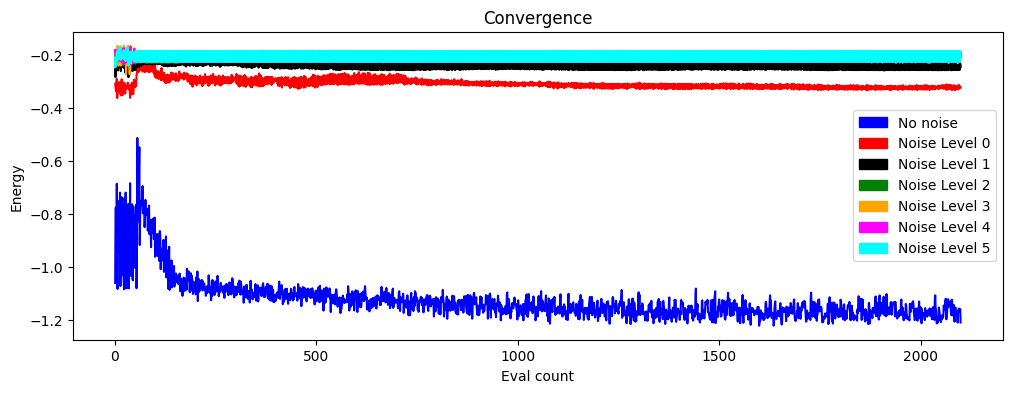

In [147]:
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches

colors = ["red", "black", "green", "orange", "magenta", "cyan"]

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(noiseless_counts, noiseless_values, color = "blue", label="No noise")
patches = []
patch1 = mpatches.Patch(color="blue", label='No noise') 
patches.append(patch1)
for index, noisy_count in enumerate(noisy_counts): 
    pylab.plot(noisy_count, noisy_values[index], color = colors[index], label="Noise Level " + str(index))
    patch = mpatches.Patch(color = colors[index], label="Noise Level " + str(index)) 
    patches.append(patch)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence")
pylab.legend(handles=patches)

In [149]:
import numpy as np

def get_error_mitigated_value(results, probabilities): 
    arr = []
    for res, prob in zip(results,probabilities): 
        arr.append([prob, res]) 

    # data = np.array(arr)
    data = np.array(arr)

    # Extract the two columns as separate arrays
    x = data[:, 0]
    y = data[:, 1]
    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    y0 = p(0)
    print(y0)
    return y0


In [ ]:
def LiH_VQE(distance, noise, mitigated):
    molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
    LiH_driver = PySCFDriver(
    atom=molecule.format(distance/2),
    basis="sto3g",
    # charge=0,
    # spin=0,
    unit=DistanceUnit.ANGSTROM,
    )
    LiH_qubit_op, qubit_converter, LiH_hamiltonian = get_qubit_op_from_molecule(LiH_driver)
    num_qubits = LiH_qubit_op.num_qubits
    num_particles = LiH_hamiltonian.num_particles 
    num_spin_orbitals = LiH_hamiltonian.num_spin_orbitals
    num_spatial_orbitals = LiH_hamiltonian.num_spatial_orbitals
    initial_state = HartreeFock(num_particles=num_particles, num_spatial_orbitals=num_spatial_orbitals,qubit_converter=qubit_converter)
    # hha_ansatz = EfficientSU2(num_qubits,entanglement='circular', reps=1)
    ansatz = UCC(
        qubit_converter=qubit_converter,
        num_particles=num_particles, 
        num_spin_orbitals=num_spin_orbitals,
        excitations='sd',
        initial_state=initial_state
    )
    optimizer = SPSA(maxiter=500, last_avg=1)
    seed = 150
    algorithm_globals.random_seed = seed
    shots = 1024
    gradient = FiniteDiffEstimatorGradient(noiseless_estimator, epsilon=0.01)
    if not noise: 
        estimator = AerEstimator(
            run_options={"seed": seed, "shots": shots},
            transpile_options={"seed_transpiler": seed},
        )
    else:
        p_reset = 0.1
        p_meas = 0.4
        p_gate1 = 0.05 
        p1Q = 0.05 
        p2Q = 0.30 
        noise_model = NoiseModel() 
        error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
        error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
        error_gate2 = error_gate1.tensor(error_gate1)
        error_reset = reset_error(p_reset, 1-p_reset)
        noise_model.add_all_qubit_quantum_error(error_gate1, ['rz', 'sx', 'u1', 'u2', 'u3'])
        noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1),  ['x'])
        estimator = AerEstimator(
                backend_options={
                    "noise_model": noise_model,
                },
                run_options={"seed": seed, "shots": shots},
                transpile_options={"seed_transpiler": seed},
            )
    if not mitigated: 
        gradient = FiniteDiffEstimatorGradient(noiseless_estimator, epsilon=0.01)
        backend = Aer.get_backend('aer_simulator')
        vqe = VQE(estimator, ansatz, optimizer,gradient=gradient, initial_point=initial_point)
        result = vqe.compute_minimum_eigenvalue(LiH_qubit_op)
        return result.eigenvalue.real

    else: 
        p_reset = 0.1
        p_meas = 0.4
        p_gate1 = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3] 
        p1Q = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
        p2Q = [0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

        noisy_estimators = [] 

        for (p_gate, p1q, p2q) in zip(p_gate1, p1Q, p2Q): 
            noise_model_device = NoiseModel.from_backend(device)
            noise_model = NoiseModel() 
            error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
            error_gate1 = pauli_error([('X',p_gate), ('I', 1 - p_gate)])
            error_gate2 = error_gate1.tensor(error_gate1)
            error_reset = reset_error(p_reset, 1-p_reset)
            noise_model.add_all_qubit_quantum_error(error_gate1, ['rz', 'sx', 'u1', 'u2', 'u3'])
            noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1),  ['x'])
            noisy_estimator = AerEstimator(
                    backend_options={
                        # "method": "density_matrix",
                        # "coupling_map": coupling_map,
                        "noise_model": noise_model,
                    },
                    run_options={"seed": seed, "shots": shots},
                    transpile_options={"seed_transpiler": seed},
                )
            noisy_estimators.append(noisy_estimator)
        results = []
        probabilities = [] 
        for index, noisy_estimator in enumerate(noisy_estimators): 
            vqe = VQE(noisy_estimator, ansatz, optimizer, gradient=gradient, initial_point=initial_point)
            noisy_result = vqe.compute_minimum_eigenvalue(LiH_qubit_op)
            noise_probability = get_noise_probability(len(counts), get_circuit_gate_counts(noisy_result), p_gate1[index], p1Q[index], p2Q[index])
            probabilities.append(noise_probability)
            calc = GroundStateEigensolver(qubit_converter, vqe)
            results.append(noisy_result.eigenvalue.real)
        mitigated_result = get_error_mitigated_value(results, probabilities)
        return mitigated_result
         
     

In [108]:
algorithms = ['NoNoise', 'Noise', 'Mitigated']

pts  = [x * 0.1  for x in range(6, 20)]
pts += [x * 0.25 for x in range(8, 16)]
pts += [4.0]
energies = np.empty([len(algorithms), len(pts)])
hf_energies = np.empty(len(pts))
distances = np.empty(len(pts))
dipoles     = np.empty([len(algorithms), len(pts)])
eval_counts = np.empty(len(pts))

print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), flush=True)
    for j in range(len(algorithms)):   
        # driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
        # qmolecule = driver.run()
        # operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
        #                         two_qubit_reduction=True, freeze_core=True,
        #                         orbital_reduction=[-3, -2])
        # qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j] == 'NoNoise':
            result = LiH_VQE(d, False, False)
        elif algorithms[j] == 'Noise':
            result = LiH_VQE(d, True, False)
        else: 
            result = LiH_VQE(d, True, True)
        print(algorithms[j], result)
        
            # optimizer = SLSQP(maxiter=1000)
            # initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
            #                             operator.molecule_info['num_particles'],
            #                             qubit_mapping=operator._qubit_mapping,
            #                             two_qubit_reduction=operator._two_qubit_reduction)
            # var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
            #                 num_particles=operator.molecule_info['num_particles'],
            #                 initial_state=initial_state,
            #                 qubit_mapping=operator._qubit_mapping,
            #                 two_qubit_reduction=operator._two_qubit_reduction)
            # algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
            # result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
            # eval_counts[i] = result.optimizer_evals
            
        # result = operator.process_algorithm_result(result)
        energies[j][i] = result
        # hf_energies[i] = result.hartree_fock_energy
        # dipoles[j][i]  = result.total_dipole_moment / 0.393430307

    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
# print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)

Processing step  0
NoNoise -1.335636155817891
Noise -0.8009491476844295
-0.9942320780614156
Mitigated -0.9942320780614156
 1
NoNoise -1.1869544301584898
Noise -0.7877986882695883
-0.9291940275278737
Mitigated -0.9291940275278737
 2
NoNoise -1.131512900401683
Noise -0.80506332174862
-0.9483551178171933
Mitigated -0.9483551178171933
 3
NoNoise -1.1078894368264867
Noise -0.829479396260281
-1.0173085647883842
Mitigated -1.0173085647883842
 4
NoNoise -1.1925236901495129
Noise -0.8182223488714666
-1.0138277260888189
Mitigated -1.0138277260888189
 5
NoNoise -1.1103040656791967
Noise -0.7942776536899113
-0.9770512925534048
Mitigated -0.9770512925534048
 6
NoNoise -1.2090263566191544
Noise -0.778873099067693
-0.9567088003105648
Mitigated -0.9567088003105648
 7
NoNoise -1.0735518735776768
Noise -0.7606469179705678
-0.9184409604303029
Mitigated -0.9184409604303029
 8
NoNoise -1.022980234185112
Noise -0.7488416687148183
-1.0510331914248117
Mitigated -1.0510331914248117
 9
NoNoise -1.00682637183774

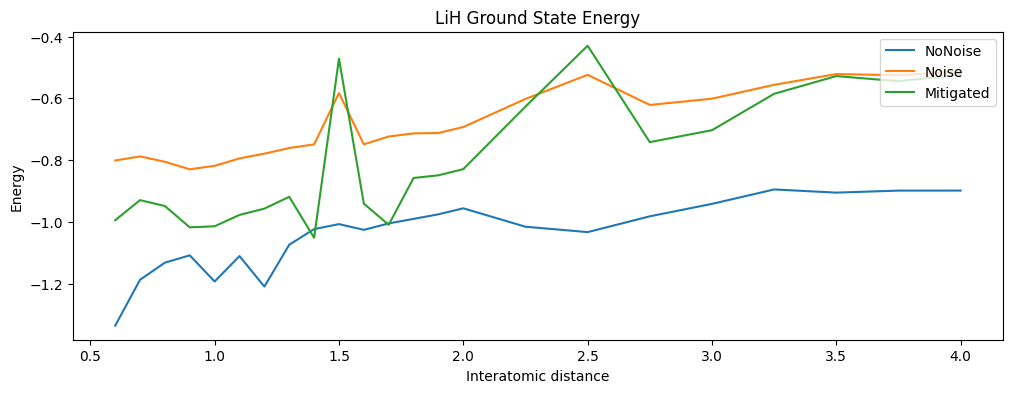

In [109]:
# pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right');